<a href="https://colab.research.google.com/github/ayberkozcan/image-recognition-pytorch/blob/main/Image_Classification_with_OxfordIIITPet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pet Recognition using OxfordIIITPet

## Importing Libraries

In [80]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}\nTorchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124


In [81]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Downloading Dataset

In [82]:
train_data = datasets.OxfordIIITPet(
    root="data/train",
    split="trainval",
    transform=ToTensor(),
    download=True
)
test_data = datasets.OxfordIIITPet(
    root="data/test",
    split="test",
    transform=ToTensor(),
    download=True
)

## Exploring Dataset

In [83]:
print(f"Train data length: {len(train_data)}")
print(f"Test data length: {len(test_data)}")

Train data length: 3680
Test data length: 3669


There are 3680 training samples and 3669 testing samples in this dataset.

Let's see classes.

In [84]:
class_names = train_data.classes

print(f"Class shape: {len(class_names)}\n")
print(f"Classes:")
for class_name in class_names:
  print(class_name)

Class shape: 37

Classes:
Abyssinian
American Bulldog
American Pit Bull Terrier
Basset Hound
Beagle
Bengal
Birman
Bombay
Boxer
British Shorthair
Chihuahua
Egyptian Mau
English Cocker Spaniel
English Setter
German Shorthaired
Great Pyrenees
Havanese
Japanese Chin
Keeshond
Leonberger
Maine Coon
Miniature Pinscher
Newfoundland
Persian
Pomeranian
Pug
Ragdoll
Russian Blue
Saint Bernard
Samoyed
Scottish Terrier
Shiba Inu
Siamese
Sphynx
Staffordshire Bull Terrier
Wheaten Terrier
Yorkshire Terrier


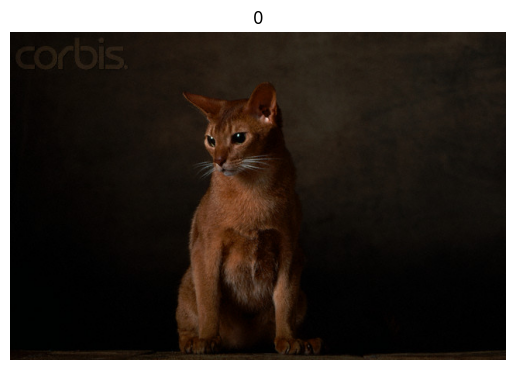

In [85]:
image, label = train_data[15]

plt.imshow(image.permute(1, 2, 0))
plt.title(label)
plt.axis("Off");

In [86]:
print(f"Image shape: {image.shape}")

Image shape: torch.Size([3, 423, 640])


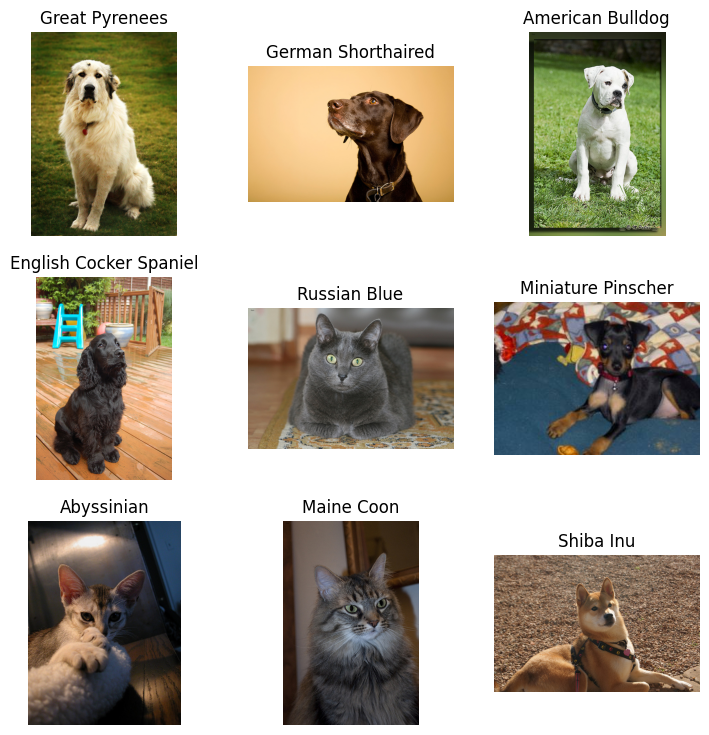

In [87]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 3, 3

for i in range(1, rows * cols + 1):
  random_number = torch.randint(0, len(train_data), size=[1]).item()
  image, label = train_data[random_number]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.permute(1, 2, 0))
  plt.title(class_names[label])
  plt.axis("Off")

plt.show()

## Writing Functions

Let's create a directory to store functions first.

In [88]:
import os

os.makedirs("src", exist_ok=True)

### prepare_data.py

In [89]:
%%writefile src/prepare_data.py

import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def prepare_data(train_dir, test_dir):
    transform = transforms.Compose([
        transforms.Resize((423, 640)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_data = datasets.OxfordIIITPet(
        train_dir,
        split="trainval",
        transform=transform,
        download=False
    )

    test_data = datasets.OxfordIIITPet(
        test_dir,
        split="test",
        transform=transform,
        download=False
    )

    print("\n[INFO] Dataset is ready\n")

    class_names = train_data.classes

    train_dataloader = DataLoader(
        train_data,
        batch_size=32,
        shuffle=True,
        num_workers=0,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=32,
        shuffle=False,
        num_workers=0
    )

    print("\n[INFO] Dataloaders are ready\n")

    return train_dataloader, test_dataloader, class_names

Overwriting src/prepare_data.py


### freeze_layers.py

In [90]:
%%writefile src/freeze_layers.py

import torch
import torchvision.models

def freeze_layers(model, class_names, device):
    for param in model.parameters():
        param.requires_grad = False

    if hasattr(model, "features") and hasattr(model, "classifier"):
        # For EfficientNet
        in_shape = model.classifier[1].in_features
        model.classifier = torch.nn.Sequential(
            torch.nn.Dropout(p=0.2, inplace=True),
            torch.nn.Linear(in_features=in_shape, out_features=len(class_names), bias=True)
        )

    elif hasattr(model, "fc"):
        # For ResNet
        in_shape = model.fc.in_features
        model.fc = torch.nn.Linear(in_features=in_shape, out_features=len(class_names), bias=True)

    else:
        raise TypeError("Unsupported model type. Only EfficientNet and ResNet are supported.")

    model.to(device)
    return model

Overwriting src/freeze_layers.py


### train_model.py

In [91]:
%%writefile src/train_model.py

import torch
from torch import nn

def train_model(model, learning_rate, epoch_number, train_dataloader, test_dataloader, device):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

    def accuracy_fn(y_true, y_pred):
        correct = torch.eq(y_true, y_pred).sum().item()
        acc = (correct / len(y_pred)) * 100
        return acc

    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    from tqdm.auto import tqdm

    from timeit import default_timer as timer
    train_time_start = timer()

    epochs = epoch_number

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch}\n--------")

        train_loss, train_acc = 0, 0

        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)

            model.train()

            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            train_loss += loss

            train_acc += accuracy_fn(
                y_true=y,
                y_pred=y_pred.argmax(dim=1)
            )

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            if batch % 400 == 0:
                print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

            train_loss /= len(train_dataloader)
            train_acc /= len(train_dataloader)

            test_loss, test_acc = 0, 0

            model.eval()
            with torch.inference_mode():
                for X, y in test_dataloader:
                    X, y = X.to(device), y.to(device)

                    test_pred = model(X)

                    loss = loss_fn(test_pred, y)
                    test_loss += loss

                    accuracy = accuracy_fn(
                        y_true=y,
                        y_pred=test_pred.argmax(dim=1)
                    )

                    test_acc += accuracy

                    test_loss /= len(test_dataloader)
                    test_acc /= len(test_dataloader)

                print(f"\nTrain Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.2f}%, Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:2f}%")

                results["train_loss"].append(train_loss.item()) if isinstance(train_loss, torch.Tensor) else train_loss
                results["train_acc"].append(train_acc.item()) if isinstance(train_acc, torch.Tensor) else train_acc
                results["test_loss"].append(test_loss.item()) if isinstance(test_loss, torch.Tensor) else test_loss
                results["test_acc"].append(test_acc.item()) if isinstance(test_acc, torch.Tensor) else test_acc

            train_time_end = timer()
            total_time = train_time_end - train_time_start

            print(f"Total Time: {total_time}")

    return results, total_time

Overwriting src/train_model.py


### save_model.py

In [92]:
%%writefile src/save_model.py

import torch
from pathlib import Path

def save_model(model, target_dir, model_name):
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(
        parents=True,
        exist_ok=True
    )
    assert model_name.endswith(".pth") or model_name.endswith(".pt")
    model_save_path = target_dir_path / model_name

    print(f"Saving model to: {model_save_path}")
    torch.save(
        obj=model.state_dict(),
        f=model_save_path
    )

Overwriting src/save_model.py


## Preparing Data

In [93]:
from src import prepare_data

train_dir = "/content/data/train"
test_dir = "/content/data/test"

train_dataloader, test_dataloader, class_names = prepare_data.prepare_data(
    train_dir,
    test_dir
)


[INFO] Dataset is ready


[INFO] Dataloaders are ready



## Loading Models (Transfer Learning)

In this chapter, we will use a PyTorch model. After that, we will freeze its layers and modify its output shape.

We will use EfficientNetB0, ResNet18 and a custom model.

In [94]:
# For summary
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

### EfficientNetB0

In [95]:
from src import freeze_layers

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights)

model_eff0 = freeze_layers.freeze_layers(model, class_names, device)

In [96]:
summary(model=model_eff0,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 37]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### ResNet18

In [97]:
from src import freeze_layers

weights = torchvision.models.ResNet18_Weights.DEFAULT
model = torchvision.models.resnet18(weights=weights)

model_resnet = freeze_layers.freeze_layers(model, class_names, device)

In [98]:
summary(model=model_resnet,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 37]             --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    

### Custom Model

In [99]:
import torch.nn.functional as F

In [100]:
class CustomModel(nn.Module):
  def __init__(self, input_shape, hidden_units=64, output_shape=37):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )
  def forward(self, x):
    return self.layer_stack(x)

In [101]:
model_custom = CustomModel(
    input_shape= 3 * 224 * 224,
    hidden_units= 64,
    output_shape=len(class_names)
).to(device)

In [102]:
summary(model=model_custom,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CustomModel (CustomModel)                [32, 3, 224, 224]    [32, 37]             --                   True
├─Sequential (layer_stack)               [32, 3, 224, 224]    [32, 37]             --                   True
│    └─Flatten (0)                       [32, 3, 224, 224]    [32, 150528]         --                   --
│    └─Linear (1)                        [32, 150528]         [32, 64]             9,633,856            True
│    └─ReLU (2)                          [32, 64]             [32, 64]             --                   --
│    └─Linear (3)                        [32, 64]             [32, 37]             2,405                True
Total params: 9,636,261
Trainable params: 9,636,261
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 308.36
Input size (MB): 19.27
Forward/backward pass size (MB): 0.03
Params size (MB): 38.55
Estimated Total Size (MB): 57.84

Our models are ready. Let's train them now.

## Training